In [2]:
from transformers import T5Tokenizer, T5Model, T5EncoderModel
import re
import torch


tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_bfd', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd")

Some weights of the model checkpoint at Rostlab/prot_t5_xl_bfd were not used when initializing T5EncoderModel: ['decoder.block.9.layer.0.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.1.EncDecAttention.o.weight', 'decoder.block.19.layer.2.DenseReluDense.wo.weight', 'decoder.block.19.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.2.DenseReluDense.wo.weight', 'decoder.block.14.layer.0.SelfAttention.o.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.20.layer.0.layer_norm.weight', 'decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.14.layer.2.DenseReluDense.wi.weight', 'decoder.block.9.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.1.EncDecAttention.q.weight', 'decoder.block.18.layer.1.EncDecAttention.q.weight', 'de

In [19]:
import pandas as pd
import numpy as np

i_seq = 0
sequences = []
seq_df = pd.read_csv("data/genbank_spike_prot_clades.csv", sep=",")

seq_df = seq_df.sample(frac=1).reset_index(drop=True)
n_seqs = 500
batch_size = 10

for row in seq_df.iterrows():
    seq = row[1]["Sequence"]
    seq = re.sub("\*", "", seq)
    sequences.append(" ".join(seq))
    i_seq += 1
    if i_seq == n_seqs:
        break

In [21]:
len(sequences)

500

In [23]:
# map rarely occured amino acids (U,Z,O,B) to (X)
print("mapping to rare amino acids...")
#sequences = ["A E T C Z A O", "S K T Z P M V"]
sequences = [re.sub(r"[UZOJB]", "X", sequence) for sequence in sequences]
# Tokenize, encode sequences and load it into the GPU if possibile

print("tokenization...")
ids = tokenizer.batch_encode_plus(
    sequences, add_special_tokens=True, padding=True
)
input_ids = torch.tensor(ids["input_ids"])
attention_mask = torch.tensor(ids["attention_mask"])

input_ids.shape, attention_mask.shape

mapping to rare amino acids...
tokenization...


(torch.Size([500, 1274]), torch.Size([500, 1274]))

In [25]:
print("computing embedding...")

agg_embedding = list()

for i in range(int(len(sequences) / batch_size)):
    curr = i * batch_size
    nex = i * batch_size + batch_size
    with torch.no_grad():
        embedding = model(input_ids=input_ids[curr:nex,], attention_mask=attention_mask[curr:nex,])
    embedding = embedding.last_hidden_state.cpu().numpy()
    agg_embedding.extend(embedding)
print("embedding computed")

computing embedding...
embedding computed


In [27]:
agg_embedding = np.array(agg_embedding)
agg_embedding.shape

(500, 1274, 1024)

In [28]:
def save_embedding():
    import h5py
    hf = h5py.File('data/save_agg_embedding_{}.h5'.format(str(len(sequences))), 'w')
    hf.create_dataset('embedding', data=agg_embedding)
    hf.close()
save_embedding()

In [29]:
import numpy as np
features = []
agg_features = []
for seq_num in range(len(agg_embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = agg_embedding[seq_num][: seq_len - 1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

In [30]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

X = np.array(agg_features)
X.shape

(500, 1024)

<ipython-input-31-9354bbe7667d>:15: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:n_seqs], palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")


[Text(0.5, 1.0, 'T-SNE projection')]

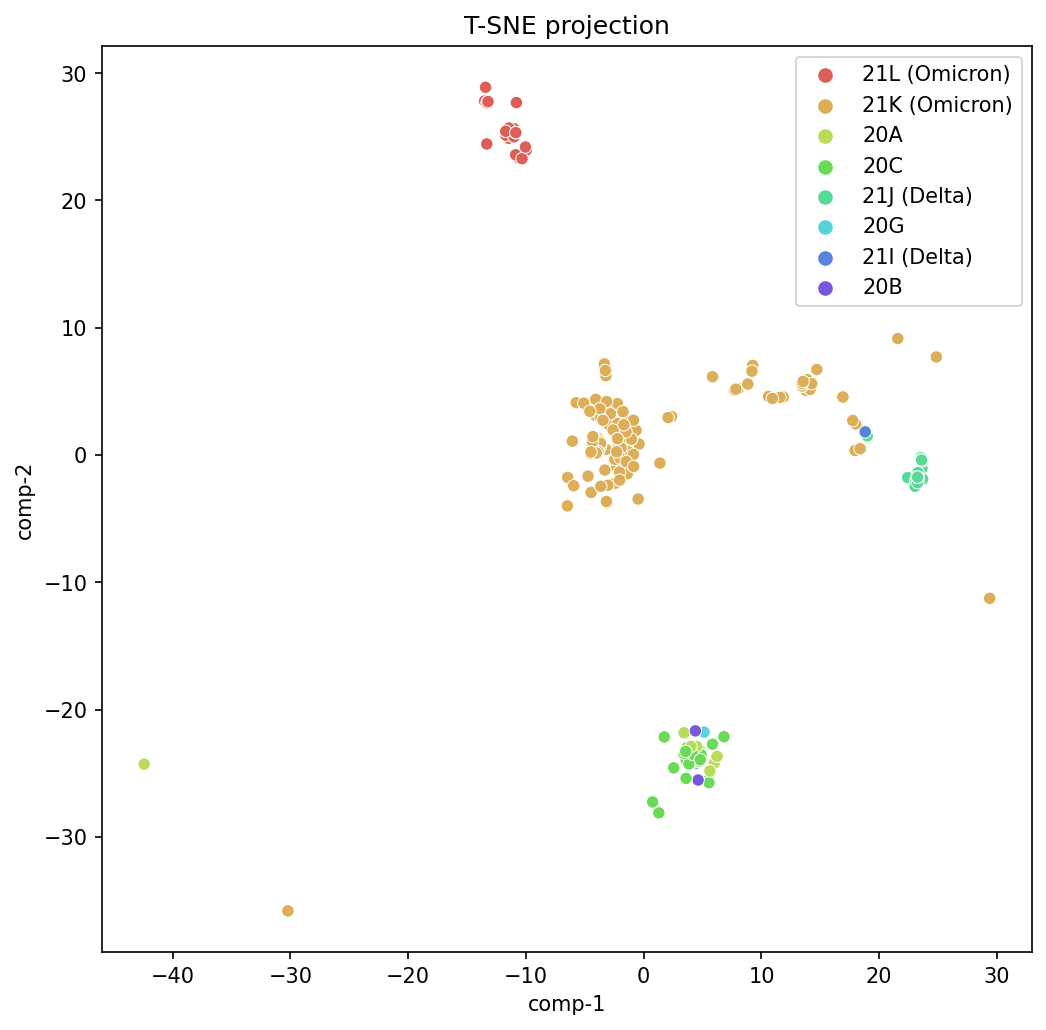

In [31]:
from matplotlib.pyplot import figure

perplexity = 20
n_colors = 10
figsize = (8, 8)

figure(figsize=figsize, dpi=150)

z = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:n_seqs], palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")

<ipython-input-32-21fe324700f8>:19: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:n_seqs], palette=sns.color_palette("hls", n_colors), data=df_umap).set(title="UMAP projection")


[Text(0.5, 1.0, 'UMAP projection')]

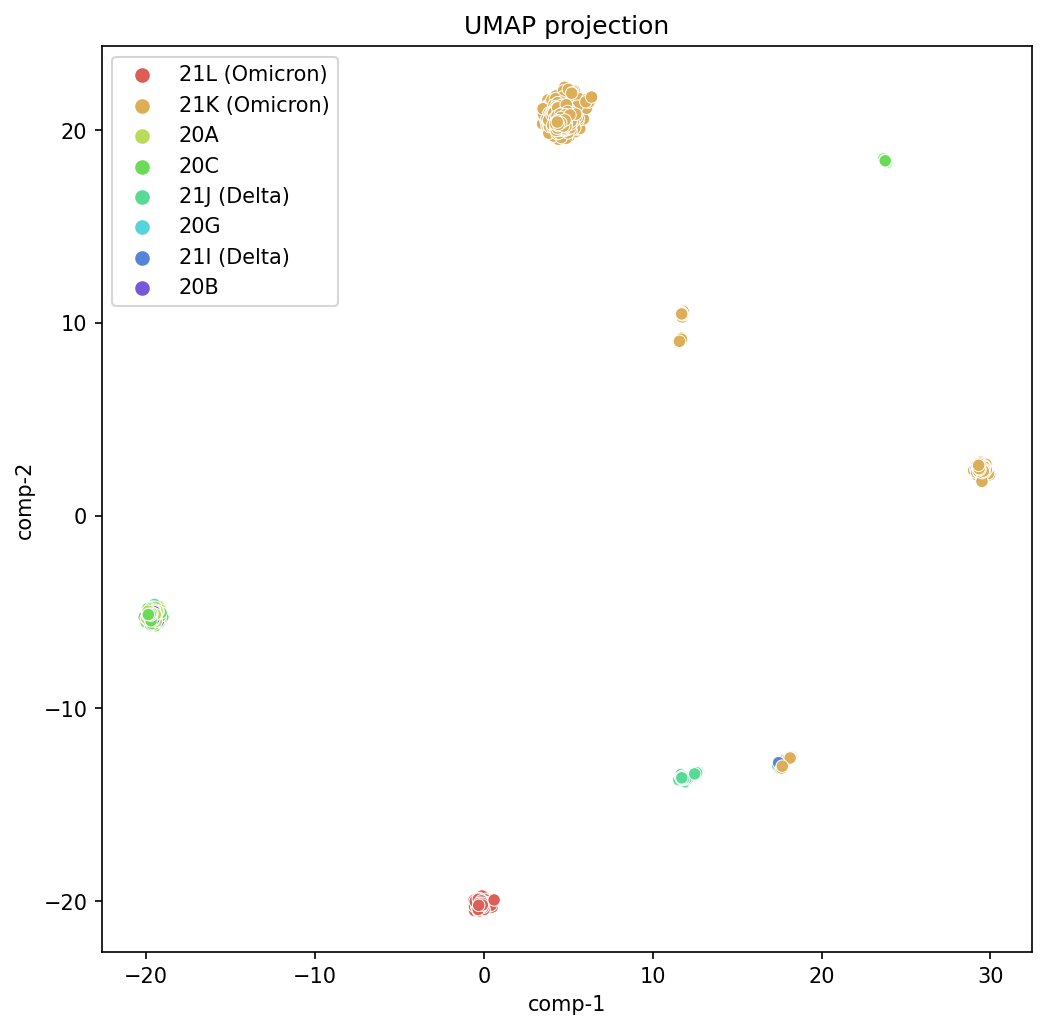

In [32]:
from umap import UMAP

figure(figsize=figsize, dpi=150)

n_colors = 10
n_neighbors=15
min_dist=0.01
n_components=2
metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=20, min_dist=0.1, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)

df_umap = pd.DataFrame()
df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:n_seqs], palette=sns.color_palette("hls", n_colors), data=df_umap).set(title="UMAP projection")